In [78]:
# ===== Импорт и базовые настройки =====
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

PLOTS_DIR = Path.cwd() / "plots"
PLOTS_DIR.mkdir(parents=True, exist_ok=True)

pd.set_option("display.max_rows", 10)
pd.set_option("display.float_format", lambda v: f"{v:,.2f}")

In [67]:
# ===== Конфигурация путей и as-of даты =====
# Проверь путь к данным под свою машину
DATA_DIR = Path(r"C:\Users\anige\PycharmProjects\Devim\data")

ORDERS_CSV   = DATA_DIR / "orders.csv"
PAYMENTS_CSV = DATA_DIR / "payments.csv"
PLAN_CSV     = DATA_DIR / "plan.csv"

# Дата актуальности выгрузки (из ТЗ): всё позже — отсекаем
AS_OF = pd.Timestamp("2022-12-08")


In [68]:
# ===== Загрузка данных =====
def load_orders(path: Path) -> pd.DataFrame:
    """orders: даты + сумма выдачи, типы."""
    df = pd.read_csv(path, parse_dates=["created_at", "put_at", "closed_at"])
    df["order_id"]  = pd.to_numeric(df["order_id"], errors="coerce").astype("Int64")
    df["issued_sum"] = pd.to_numeric(df.get("issued_sum"), errors="coerce")
    return df

def load_payments(path: Path, as_of: pd.Timestamp) -> pd.DataFrame:
    """payments: обрезаем по AS_OF, чистим дубли, приводим типы."""
    df = pd.read_csv(path)
    df["order_id"] = pd.to_numeric(df["order_id"], errors="coerce").astype("Int64")
    df["paid_at"]  = pd.to_datetime(df["paid_at"], errors="coerce")
    df["paid_sum"] = pd.to_numeric(df.get("paid_sum"), errors="coerce")
    df = df.drop_duplicates(subset=["order_id","paid_at","paid_sum"])
    df = df.dropna(subset=["order_id","paid_at","paid_sum"])
    df = df[df["paid_at"] <= as_of]
    return df

def load_plan(path: Path, as_of: pd.Timestamp) -> pd.DataFrame:
    """plan: накопительный план, обрезаем по AS_OF, типы."""
    df = pd.read_csv(path)
    df["order_id"]       = pd.to_numeric(df["order_id"], errors="coerce").astype("Int64")
    df["plan_at"]        = pd.to_datetime(df["plan_at"], errors="coerce")
    df["plan_sum_total"] = pd.to_numeric(df.get("plan_sum_total"), errors="coerce")
    df = df.dropna(subset=["order_id","plan_at"])
    df = df[df["plan_at"] <= as_of]
    return df

orders   = load_orders(ORDERS_CSV)
payments = load_payments(PAYMENTS_CSV, AS_OF)
plan     = load_plan(PLAN_CSV, AS_OF)

print("Загружено:", orders.shape, payments.shape, plan.shape)
display(orders.head(3)); display(payments.head(3)); display(plan.head(3))


Загружено: (55748, 5) (143198, 3) (333399, 3)


,order_id,created_at,put_at,closed_at,issued_sum
0,400001732,2022-06-02 00:00:23.997,2022-06-02 20:18:00.180,2022-10-17 11:52:22.190,"13,600.00"
1,400005838,2022-06-02 00:10:22.997,2022-06-02 15:41:33.267,2022-06-02 17:38:43.917,"20,000.00"
2,400007915,2022-06-02 00:18:04.000,2022-06-05 19:17:38.547,2022-06-21 21:55:51.877,"5,820.00"


,order_id,paid_at,paid_sum
0,400013633,2022-06-02 00:48:13.800,"2,500.00"
1,400018480,2022-06-02 01:52:05.707,"1,070.00"
2,400032001,2022-06-02 04:55:40.307,"4,200.00"


,order_id,plan_at,plan_sum_total
0,400001732,2022-06-02,"5,600.00"
1,400001732,2022-07-02,"9,450.00"
2,400001732,2022-08-01,"12,170.00"


In [69]:
# ===== Качество данных =====
def show_quality(orders: pd.DataFrame, payments: pd.DataFrame, plan: pd.DataFrame) -> None:
    print(" Дубликаты")
    print("  orders by order_id:", orders.duplicated(["order_id"]).sum())
    print("  payments by (order_id, paid_at, paid_sum):", payments.duplicated(["order_id","paid_at","paid_sum"]).sum())
    print("  plan by (order_id, plan_at):", plan.duplicated(["order_id","plan_at"]).sum())
    print("\n Пропуски (ключевые)")
    print("  orders:\n", orders[["order_id","put_at","closed_at","issued_sum"]].isna().sum())
    print("  payments:\n", payments[["order_id","paid_at","paid_sum"]].isna().sum())
    print("  plan:\n", plan[["order_id","plan_at","plan_sum_total"]].isna().sum())

show_quality(orders, payments, plan)


 Дубликаты
  orders by order_id: 0
  payments by (order_id, paid_at, paid_sum): 0
  plan by (order_id, plan_at): 0

 Пропуски (ключевые)
  orders:
 order_id         0
put_at           0
closed_at     9276
issued_sum       0
dtype: int64
  payments:
 order_id    0
paid_at     0
paid_sum    0
dtype: int64
  plan:
 order_id          0
plan_at           0
plan_sum_total    0
dtype: int64


In [71]:
# ===== План должен быть накопительным и неубывающим =====
def make_plan_monotonic(plan: pd.DataFrame) -> pd.DataFrame:
    plan_fixed = plan.sort_values(["order_id","plan_at"]).copy()
    plan_fixed["plan_sum_total"] = plan_fixed.groupby("order_id")["plan_sum_total"].cummax()
    return plan_fixed

plan = make_plan_monotonic(plan)
plan.head(3)


,order_id,plan_at,plan_sum_total
0,400001732,2022-06-02,"5,600.00"
1,400001732,2022-07-02,"9,450.00"
2,400001732,2022-08-01,"12,170.00"


In [72]:
# ===== Кумулятивные фактические платежи =====
def cumulative_payments(payments: pd.DataFrame) -> pd.DataFrame:
    """Добавляем paid_cum — накопленные фактические платежи внутри заявки."""
    payments_sorted = payments.sort_values(["order_id","paid_at"]).copy()
    payments_sorted["paid_cum"] = payments_sorted.groupby("order_id")["paid_sum"].cumsum()
    return payments_sorted.reset_index(drop=True)

payments_cum = cumulative_payments(payments)
payments_cum.head(3)


,order_id,paid_at,paid_sum,paid_cum
0,400001732,2022-06-02 20:20:16.790,"5,600.00","5,600.00"
1,400001732,2022-06-16 16:05:26.007,"3,850.00","9,450.00"
2,400001732,2022-07-15 12:32:34.087,"2,720.00","12,170.00"


## Определение просрочки

**Просрочка** — это нарушение должником сроков и/или объёмов исполнения обязательств,
предусмотренных договором (графиком платежей).

В терминах наших данных:

- сравниваем накопленный **план** (`plan_sum_total`) и накопленный **факт** (`paid_cum`);
- если на дату факт < план → фиксируем просрочку;
- если должник догоняет позже → долг обнуляется, просрочка снимается.


In [73]:
# ===== Просрочка на дату планового платежа =====
def overdue_on_plan_dates(plan: pd.DataFrame, payments_cum: pd.DataFrame) -> pd.DataFrame:
    """
    Для каждой заявки:
      - берём плановую дату
      - находим последний факт ≤ этой даты
      - считаем долг = план - факт; просрочка если долг > 0
    """
    out = []
    for oid, plan_sub in plan.groupby("order_id", sort=False):
        plan_sub = plan_sub.sort_values("plan_at").reset_index(drop=True)
        pay_sub  = payments_cum.loc[payments_cum["order_id"] == oid].sort_values("paid_at").reset_index(drop=True)
        if pay_sub.empty:
            pay_sub = pd.DataFrame({"paid_at":[pd.Timestamp.min], "paid_cum":[0.0]})
        merged = pd.merge_asof(
            left=plan_sub,
            right=pay_sub,
            left_on="plan_at",
            right_on="paid_at",
            direction="backward"
        )
        merged["order_id"] = oid
        merged["paid_cum"] = merged["paid_cum"].fillna(0)
        merged["debt"] = merged["plan_sum_total"] - merged["paid_cum"]
        merged["is_overdue"] = merged["debt"] > 0
        out.append(merged)

    overdue_df = pd.concat(out, ignore_index=True)
    overdue_df["month"] = overdue_df["plan_at"].values.astype("datetime64[M]")
    return overdue_df

overdue_df = overdue_on_plan_dates(plan, payments_cum)
overdue_df.head(3)


,order_id_x,plan_at,plan_sum_total,order_id_y,paid_at,paid_sum,paid_cum,order_id,debt,is_overdue,month
0,400001732,2022-06-02,"5,600.00",<NA>,NaT,NaN,0.00,400001732,"5,600.00",True,2022-06-01
1,400001732,2022-07-02,"9,450.00",400001732,2022-06-16 16:05:26.007,"3,850.00","9,450.00",400001732,0.00,False,2022-07-01
2,400001732,2022-08-01,"12,170.00",400001732,2022-07-15 12:32:34.087,"2,720.00","12,170.00",400001732,0.00,False,2022-08-01


In [74]:
# ===== Месячная динамика по инстансам плана =====
def monthly_instalment_view(overdue_df: pd.DataFrame, as_of: pd.Timestamp) -> pd.DataFrame:
    df = overdue_df.copy()
    last_month = as_of.to_period("M").to_timestamp()
    agg = (df.groupby("month", as_index=False)
             .agg(instalments=("order_id","count"),
                  overdue_instalments=("is_overdue","sum"),
                  total_debt=("debt", lambda x: x[x>0].sum()),
                  avg_debt_overdue=("debt", lambda x: x[x>0].mean())))
    agg = agg[agg["month"] <= last_month].copy()
    agg["overdue_rate"] = agg["overdue_instalments"] / agg["instalments"]
    return agg

instalment_month = monthly_instalment_view(overdue_df, AS_OF)
instalment_month


,month,instalments,overdue_instalments,total_debt,avg_debt_overdue,overdue_rate
0,2022-06-01,17980,16390,"43,221,956.95","2,637.09",0.91
1,2022-07-01,44342,33687,"104,831,702.01","3,111.93",0.76
2,2022-08-01,66450,41816,"110,702,800.37","2,647.38",0.63
3,2022-09-01,65135,28027,"90,421,621.21","3,226.23",0.43
4,2022-10-01,62951,17732,"78,703,486.65","4,438.50",0.28
5,2022-11-01,60739,14035,"79,825,921.08","5,687.63",0.23
6,2022-12-01,15802,3310,"21,002,311.79","6,345.11",0.21


In [75]:
# ===== Снимки по клиентам (активные кредиты на конец месяца) =====
def build_month_grid(plan: pd.DataFrame, as_of: pd.Timestamp) -> pd.DataFrame:
    start = plan["plan_at"].min().to_period("M").start_time
    end   = as_of.to_period("M").end_time
    months = pd.date_range(start, end, freq="ME")   # MonthEnd (без deprecated 'M')
    return pd.DataFrame({"month_end": months})

def is_active_on(orders: pd.DataFrame, date: pd.Timestamp) -> pd.DataFrame:
    """Активный: put_at <= date и (closed_at отсутствует или > date)."""
    closed = orders["closed_at"].fillna(pd.Timestamp.max)
    mask = (orders["put_at"] <= date) & (closed > date)
    return orders.loc[mask, ["order_id"]].copy()

def month_end_snapshots(orders: pd.DataFrame, plan: pd.DataFrame, payments_cum: pd.DataFrame, as_of: pd.Timestamp) -> pd.DataFrame:
    calendar  = build_month_grid(plan, as_of)
    plan_asof = plan.sort_values(["order_id","plan_at"])[["order_id","plan_at","plan_sum_total"]]
    pay_asof  = payments_cum.sort_values(["order_id","paid_at"])[["order_id","paid_at","paid_cum"]]

    snaps_all = []
    for idx, oid in enumerate(plan_asof["order_id"].unique(), 1):
        if idx % 2000 == 0:
            print(f"  обработано заявок: {idx}")
        psub = plan_asof[plan_asof["order_id"] == oid].rename(columns={"plan_at":"date"})
        fsub = pay_asof [pay_asof ["order_id"] == oid].rename(columns={"paid_at":"date"})
        left = calendar.rename(columns={"month_end":"date"})
        snap_plan = pd.merge_asof(left, psub[["date","plan_sum_total"]], on="date", direction="backward")
        snap_pay  = pd.merge_asof(left, fsub[["date","paid_cum"]],      on="date", direction="backward")
        snap = pd.DataFrame({
            "order_id": oid,
            "month_end": left["date"],
            "plan_sum_total": snap_plan["plan_sum_total"].fillna(0),
            "paid_cum":      snap_pay["paid_cum"].fillna(0),
        })
        snaps_all.append(snap)

    snaps = pd.concat(snaps_all, ignore_index=True)
    snaps["debt"] = snaps["plan_sum_total"] - snaps["paid_cum"]
    snaps["is_overdue"] = snaps["debt"] > 0

    # активность
    marks = []
    for d in snaps["month_end"].drop_duplicates():
        active = is_active_on(orders, d)
        if not active.empty:
            active["month_end"] = d
            active["active"] = True
            marks.append(active)
    if marks:
        active_df = pd.concat(marks, ignore_index=True)
        snaps = snaps.merge(active_df, on=["order_id","month_end"], how="left")
    else:
        snaps["active"] = False

    snaps["active"] = snaps["active"].fillna(False).astype(bool)
    return snaps

snaps = month_end_snapshots(orders, plan, payments_cum, AS_OF)

clients_month = (snaps[snaps["active"]]
                 .groupby("month_end", as_index=False)
                 .agg(active_clients=("order_id","nunique"),
                      overdue_active=("is_overdue","sum"),
                      total_debt_active=("debt", lambda x: x[x>0].sum()),
                      avg_debt_overdue_active=("debt", lambda x: x[x>0].mean())))
clients_month["overdue_rate_active"] = clients_month["overdue_active"] / clients_month["active_clients"]
clients_month


  обработано заявок: 2000
  обработано заявок: 4000
  обработано заявок: 6000
  обработано заявок: 8000
  обработано заявок: 10000
  обработано заявок: 12000
  обработано заявок: 14000
  обработано заявок: 16000
  обработано заявок: 18000
  обработано заявок: 20000
  обработано заявок: 22000
  обработано заявок: 24000
  обработано заявок: 26000
  обработано заявок: 28000
  обработано заявок: 30000
  обработано заявок: 32000
  обработано заявок: 34000
  обработано заявок: 36000
  обработано заявок: 38000
  обработано заявок: 40000
  обработано заявок: 42000
  обработано заявок: 44000
  обработано заявок: 46000
  обработано заявок: 48000
  обработано заявок: 50000
  обработано заявок: 52000
  обработано заявок: 54000


C:\Users\anige\AppData\Local\Temp\ipykernel_9136\492241062.py:54: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  snaps["active"] = snaps["active"].fillna(False).astype(bool)


,month_end,active_clients,overdue_active,total_debt_active,avg_debt_overdue_active,overdue_rate_active
0,2022-06-30,11068,3089,"12,973,521.35","4,199.91",0.28
1,2022-07-31,18237,7210,"23,196,339.83","3,217.25",0.40
2,2022-08-31,23640,10392,"37,849,692.22","3,642.20",0.44
3,2022-09-30,15462,9116,"42,082,775.27","4,616.36",0.59
4,2022-10-31,12086,8140,"46,109,774.23","5,664.59",0.67
5,2022-11-30,9785,7197,"50,135,429.55","6,966.16",0.74
6,2022-12-31,9276,6939,"50,781,998.74","7,318.35",0.75


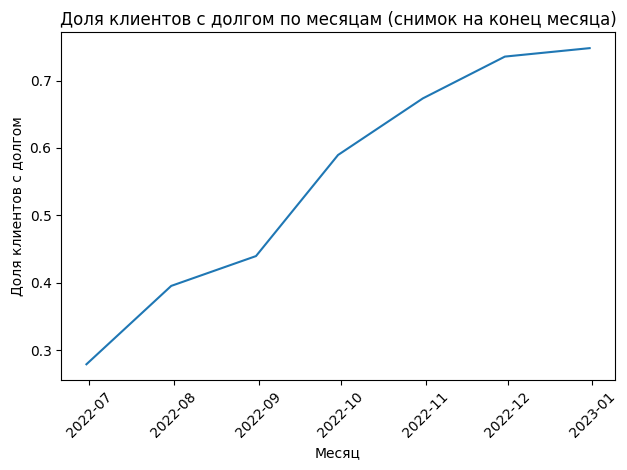

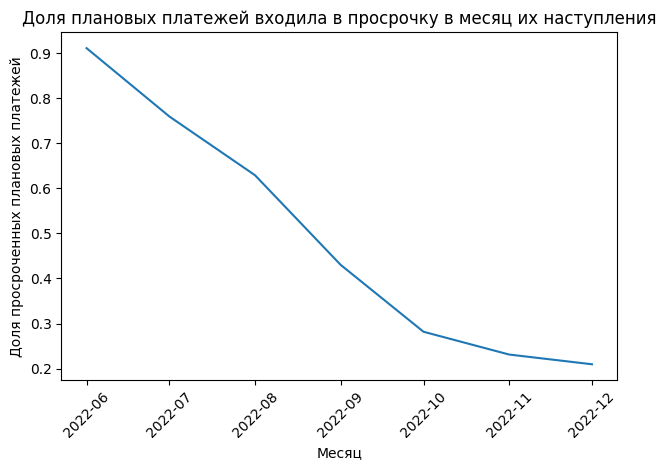

In [80]:
# ===== График 1: доля клиентов с долгом (конец месяца, активные) =====
plt.figure()
plt.plot(clients_month["month_end"], clients_month["overdue_rate_active"])
plt.title("Доля клиентов с долгом по месяцам (снимок на конец месяца)")
plt.xlabel("Месяц")
plt.ylabel("Доля клиентов с долгом")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(PLOTS_DIR / "clients.png", dpi=150, bbox_inches="tight")
plt.show()

# ===== График 2: доля просроченных плановых платежей (месяц наступления) =====
plt.figure()
plt.plot(instalment_month["month"], instalment_month["overdue_rate"])
plt.title("Доля плановых платежей входила в просрочку в месяц их наступления")
plt.xlabel("Месяц")
plt.ylabel("Доля просроченных плановых платежей")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(PLOTS_DIR / "instalments.png", dpi=150, bbox_inches="tight")
plt.show()


### Обнаруженные несостыковки и как мы их трактовали

1. **`closed_at` отсутствует у большинства заявок** — считаем их активными, чтобы не терять картину по просрочкам.
2. **`plan_sum_total` задаётся накопительным итогом** — поэтому долг определяли как разницу «план (накопит.) − факт (накопит.)».
3. **Фактические платежи после даты актуальности (2022-12-08)** могли завышать просрочку — мы отрезали их по условию.
4. **Заявки без платежей** трактовали как «100% просрочка».
5. **Дубликатов и пропусков по ключевым полям нет**, что подтверждено проверкой качества.

Это гарантирует, что выводы по динамике просрочки корректны, несмотря на особенности данных.


In [58]:
# ===== Резюме в 3–5 строк =====
def print_summary_text():
    print("Определение: просрочка по сумме — долг = план(накопит.) − факт(накопит.) > 0 на дату.")

    if not clients_month.empty:
        first = clients_month["overdue_rate_active"].iloc[0]
        last  = clients_month["overdue_rate_active"].iloc[-1]
        print(f"Снимок по клиентам: доля с долгом изменилась с {first:.1%} до {last:.1%}.")

    if not instalment_month.empty:
        peak_idx = instalment_month["overdue_rate"].idxmax()
        peak_row = instalment_month.loc[peak_idx]
        print(f"По плановым платежам: максимум {peak_row['overdue_rate']:.1%} в {peak_row['month'].strftime('%Y-%m')}.")

    print("Мы учитываем дату актуальности (2022-12-08), чтобы не завышать просрочку после конца выгрузки.")

print_summary_text()


Определение: просрочка по сумме — долг = план(накопит.) − факт(накопит.) > 0 на дату.
Снимок по клиентам: доля с долгом изменилась с 27.9% до 74.8%.
По плановым платежам: максимум 91.2% в 2022-06.
Мы учитываем дату актуальности (2022-12-08), чтобы не завышать просрочку после конца выгрузки.


In [59]:
# ===== Сохранение таблиц (если нужно приложить к ответу) =====
OUT_DIR = Path.cwd() / "output"
(OUT_DIR / "tables").mkdir(parents=True, exist_ok=True)

instalment_month.to_csv(OUT_DIR / "tables" / "instalment_month.csv", index=False)
clients_month.to_csv(OUT_DIR / "tables" / "clients_month.csv", index=False)

print("Сохранено в:", OUT_DIR / "tables")


Сохранено в: C:\Users\anige\PycharmProjects\Devim\src\output\tables


---

##  Итоги анализа

 **Определение**: просрочка считается просто — долг возникает, если на дату сумма по плану накопилась больше, чем факт (план − факт > 0).

 **Снимок по клиентам**: доля с долгом за весь период выросла заметно — с **27.9%** до **74.8%**.

 **По плановым платежам**: пик пришёлся на **июнь 2022**, где просрочено было до **91.2%** платежей.

 **Дата актуальности данных**: мы фиксируем срез на **08.12.2022**, чтобы не завышать просрочку после конца выгрузки.

 **Итог**: динамика просрочки явно растущая — ситуация ухудшалась к концу периода.
